## 이 Jupyter Notebook 파일은 Rain in Austrailia Dataset에 대한 전처리를 위한 셀입니다.

### 먼저 데이터셋을 지역별로 나누고, NaN이 100%에 육박하지 않는 column들만 추출하며, 지역별로 나누어진 데이터셋 중 NaN이 적은, 그리고 label에 NaN이 없는 데이터셋만 따로 추출하겠습니다.

### 추출된 데이터셋(label에 NaN이 없는 데이터셋)을 PCA를 통해 feature를 4차원으로 축소시키고 csv로 저장하도록 하겠습니다.

### 1번. 지역별 Dataframe을 dict에 저장한다.

dict : key(location)-value(dataframe)

In [176]:
# Quantum
import pennylane as qml
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Numpy, Pandas
import numpy as np
import pandas as pd
# Layer
from RNN_block import RNN_block
# Data processing
from sklearn.preprocessing import MinMaxScaler

In [177]:
class data_pre:
    def __init__(self, filename = "./weatherAUS.csv", chk = False):
        self.df = pd.read_csv(filename)
        
        df = self.df
        locations = df['Location'].unique()
        self.location_dfs = {location: df[df['Location'] == location].reset_index(drop=False) for location in locations}
        
        if chk:
            print(self.df.keys())
    
    def make_data_with_keys(self, key_features, key_label):
        train_data_dict = dict()
        label_data_dict = dict()
        for e in self.location_dfs:
            train_data_dict[e] = self.location_dfs[e][key_features]

            label_data_dict[e] = self.location_dfs[e][[key_label]]
            label_data_dict[e].loc[label_data_dict[e]['RainTomorrow'] == 'Yes', 'RainTomorrow'] = 1
            label_data_dict[e].loc[label_data_dict[e]['RainTomorrow'] == 'No', 'RainTomorrow'] = -1
        return train_data_dict, label_data_dict

    def chk_distribution(self, location = "all"):
        location_dict = self.location_dfs
        for e in location_dict:
            if location == "all" or e == location:
                df = location_dict[e]
                print(f"\n\n======== {e} ========")
                print('==== MEAN ====')
                print(df[['MinTemp', 'MaxTemp']].mean())
                print('==== STD ====')
                print(df[['MinTemp', 'MaxTemp']].std())

    def split_about_location(self):
        '''
            location마다의 dataframe을 딕셔너리로 만들어 return
        '''
        df = self.df
        locations = df['Location'].unique()
        location_dfs = {location: df[df['Location'] == location].reset_index(drop=True) for location in locations}
        return location_dfs
    
        

In [178]:
test_data = data_pre(chk = False)
print(test_data.df.keys())
## numerical한 모든 feature 확인
## 'Evaporation', 'Sunshine' 은 NaN만 포함하고 있어 배제

train_data_dict, label_data_dict = test_data.make_data_with_keys(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday'], 'RainTomorrow')

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


/var/folders/9q/m77q01ls5n12fr3t97v33_lh0000gn/T/ipykernel_3223/3669599204.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data_dict[e].loc[label_data_dict[e]['RainTomorrow'] == 'Yes', 'RainTomorrow'] = 1
/var/folders/9q/m77q01ls5n12fr3t97v33_lh0000gn/T/ipykernel_3223/3669599204.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_data_dict[e].loc[label_data_dict[e]['RainTomorrow'] == 'No', 'RainTomorrow'] = -1
/var/folders/9q/m77q01ls5n12fr3t97v33_lh0000gn/T/ipykernel_3223/3669599204.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

### 2번. 데이터 가공 (NaN 열 제거)

2번. 딕셔너리에 저장된 지역별 데이터프레임을 확인하고, 필요없는 열은 배제한다.

이때 필요없는 열이란 NaN이 100%에 달하는 열을 의미한다.

In [179]:
import numpy as np
import pandas as pd

# NaN이 적은 열 목록 (Dir이 포함된 열 제외)
columns_to_keep = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 
                   'WindSpeed9am', 'WindSpeed3pm', 'Humidity3pm', 
                   'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

# 결합된 데이터에서 NaN 비율이 낮은 지역을 필터링할 임계값 설정
nan_percentage_means = {}
for location, train_data in train_data_dict.items():
    # 각 지역의 train_data와 label_data 결합 (NaN 비율 계산 전 추가)
    if location in label_data_dict:
        combined_data = train_data[columns_to_keep].copy()
        combined_data['RainTomorrow'] = label_data_dict[location]['RainTomorrow']  # Label 열 추가

        # NaN 비율 계산
        nan_counts = combined_data.isna().sum()
        total_count = len(combined_data)
        nan_percentage = (nan_counts / total_count) * 100
        nan_percentage_means[location] = nan_percentage.mean()

# 전체 평균 NaN 비율을 기준으로 필터링
overall_mean_nan_percentage = np.mean(list(nan_percentage_means.values()))
low_nan_locations = [loc for loc, mean in nan_percentage_means.items() if mean < overall_mean_nan_percentage]


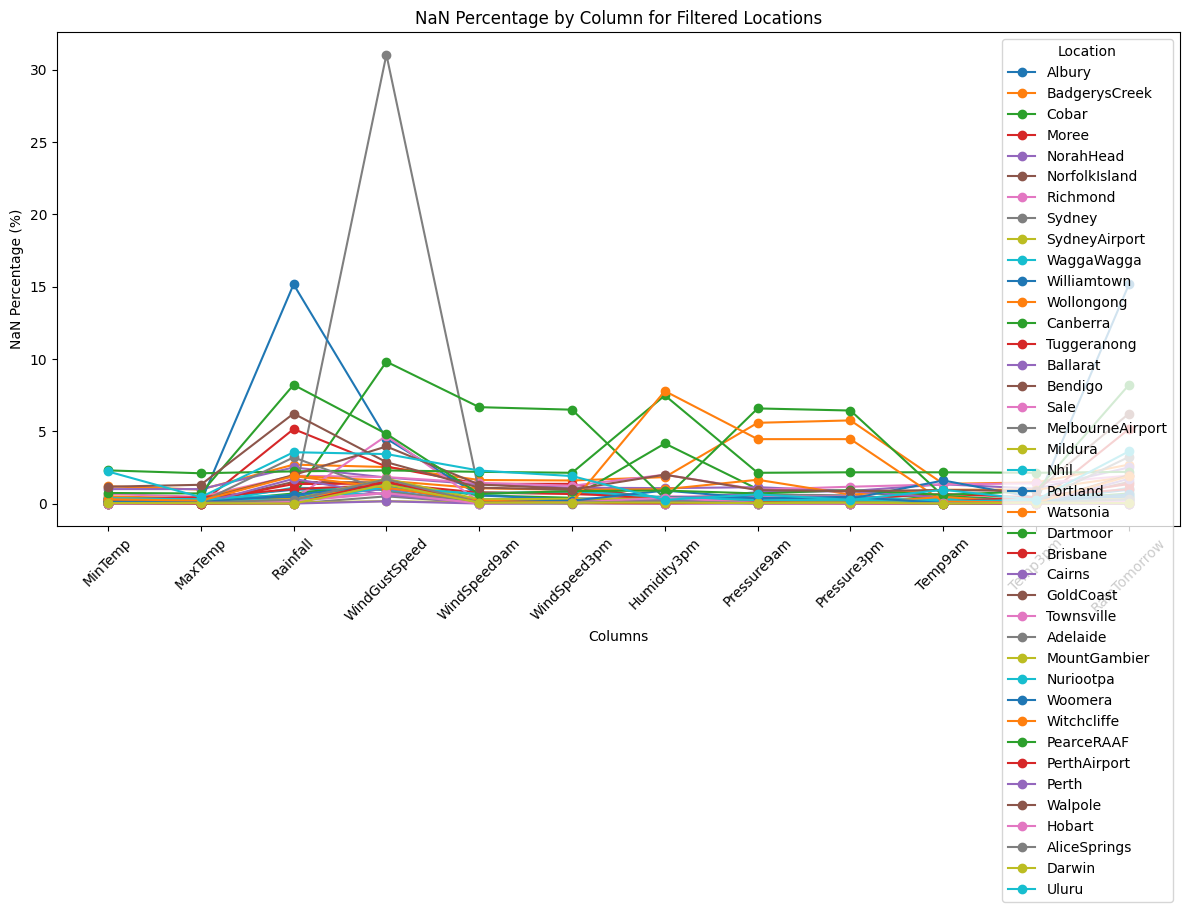

In [180]:
import matplotlib.pyplot as plt

# 각 location의 열별 NaN 비율을 계산하고 그래프로 시각화
fig, ax = plt.subplots(figsize=(12, 8))

for location in low_nan_locations:
    # 해당 지역의 데이터 가져오기
    data = train_data_dict[location][columns_to_keep].copy()
    data['RainTomorrow'] = label_data_dict[location]['RainTomorrow']  # Label 열 추가

    # 각 열별 NaN 비율 계산
    nan_percentage = data.isna().sum() / len(data) * 100

    # 꺾은선 그래프로 각 열의 NaN 비율 그리기
    ax.plot(nan_percentage.index, nan_percentage.values, label=location, marker='o')

# 그래프 세부 설정
ax.set_title('NaN Percentage by Column for Filtered Locations')
ax.set_xlabel('Columns')
ax.set_ylabel('NaN Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Location')
plt.tight_layout()
plt.show()


In [158]:
# 필터링된 지역만 처리
for location in low_nan_locations:
    train_data = train_data_dict[location][columns_to_keep].copy()  # NaN이 적은 열들만 선택
    train_data['RainTomorrow'] = label_data_dict[location]['RainTomorrow']  # Label 열 추가

    # NaN을 각 열의 평균으로 채우기
    for col in train_data.columns:
        if train_data[col].dtype in ['float64', 'int64']:  # 수치형 열만
            train_data[col].fillna(train_data[col].mean(), inplace=True)

    # Label 열 분리하여 저장
    label_data = train_data[['RainTomorrow']].copy()  # Label만 분리
    label_data['RainTomorrow'].fillna(0, inplace=True)  # Label의 NaN을 0으로 채우기
    train_data.drop(columns=['RainTomorrow'], inplace=True)  # train_data에서 Label 제거

    # 파일로 내보내기
    train_filename = f"./data/filtered/filtered_train_data_{location}.csv"
    label_filename = f"./data/filtered/filtered_label_data_{location}.csv"
    train_data.to_csv(train_filename, index=False)
    label_data.to_csv(label_filename, index=False)

    print(f"Saved filtered train data to {train_filename} and label data to {label_filename}")

/var/folders/9q/m77q01ls5n12fr3t97v33_lh0000gn/T/ipykernel_3223/2930336609.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].mean(), inplace=True)
/var/folders/9q/m77q01ls5n12fr3t97v33_lh0000gn/T/ipykernel_3223/2930336609.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

Saved filtered train data to ./data/filtered/filtered_train_data_Albury.csv and label data to ./data/filtered/filtered_label_data_Albury.csv
Saved filtered train data to ./data/filtered/filtered_train_data_BadgerysCreek.csv and label data to ./data/filtered/filtered_label_data_BadgerysCreek.csv
Saved filtered train data to ./data/filtered/filtered_train_data_Cobar.csv and label data to ./data/filtered/filtered_label_data_Cobar.csv
Saved filtered train data to ./data/filtered/filtered_train_data_Moree.csv and label data to ./data/filtered/filtered_label_data_Moree.csv
Saved filtered train data to ./data/filtered/filtered_train_data_NorahHead.csv and label data to ./data/filtered/filtered_label_data_NorahHead.csv
Saved filtered train data to ./data/filtered/filtered_train_data_NorfolkIsland.csv and label data to ./data/filtered/filtered_label_data_NorfolkIsland.csv
Saved filtered train data to ./data/filtered/filtered_train_data_Richmond.csv and label data to ./data/filtered/filtered_lab

/var/folders/9q/m77q01ls5n12fr3t97v33_lh0000gn/T/ipykernel_3223/2930336609.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].mean(), inplace=True)
/var/folders/9q/m77q01ls5n12fr3t97v33_lh0000gn/T/ipykernel_3223/2930336609.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

#### 2-1번 label에 NaN이 없는 지역 확인

In [170]:
fully_labeled_locations = []
for location in low_nan_locations:
    if label_data_dict[location]['RainTomorrow'].isna().sum() == 0:
        print('\n\nLocation :', location)
        print('total data :', len(label_data_dict[location]['RainTomorrow']))
        print(label_data_dict[location]['RainTomorrow'].isna().sum())
        fully_labeled_locations.append(location)




Location : MelbourneAirport
total data : 3009
0


Location : PerthAirport
total data : 3009
0


Location : Perth
total data : 3193
0


In [169]:
print('fully_labeld_locations :',fully_labeled_locations)

fully_labeld_locations : ['MelbourneAirport', 'PerthAirport', 'Perth']


---

### 3번. 각 지역에 대한 csv 불러오기 해서 PCA 주성분 분석 -> 4개의 주성분이면 최소 75% ~ 최대 85%까지 explain 가능

3번. 각 지역에 대한 csv를 불러오고, PCA를 통해 차원을 줄여서 다시 csv로 저장

In [216]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

class PCA_Data:
    '''
        preprocess된 CSV 파일(train, label)을 입력받아, 
        PCA를 통해 feature의 개수를 원하는 만큼 줄여서 csv로 export하기 위한 class
    '''
    # 배치된 데이터를 생성하여 바로 학습할 수 있도록 데이터를 준비해주는 class -> 이건 아님

    def __init__(self, train_path="", label_path="", location="", required_data=0, required_components=4):
        '''
            train_path(str) : path of train data csv file (ex : ./data/train_data_Darwin.csv)
            label_path(str) : path of label data csv file (ex : ./data/label_data_Darwin.csv)
            location(str) : location of Rain in Aus data (ex : Darwin)
            required_data(int) : required columns of data
            required_compononet(int) : num of feature which have to be reduced
        '''
        # 데이터 불러오기
        self.required_data = required_data
        self.required_components = required_components
        self.scaler = StandardScaler()

        if train_path != "" and label_path != "":
            self.train_path = train_path
            self.label_path = label_path
            self.location = train_path[18:-4]
        elif location != "":
            self.train_path = f'./data/filtered/filtered_train_data_{location}.csv'
            self.label_path = f'./data/filtered/filtered_label_data_{location}.csv'
            self.location = location
        else:
            print("Err : There is NO information for data...")
            return

        self.train_df = pd.read_csv(self.train_path)
        self.label_df = pd.read_csv(self.label_path)

        if required_data == 0:
            self.required_data = len(self.train_df)
        else:
            self.required_data = required_data

        self.train_df = pd.read_csv(self.train_path)[:self.required_data]
        self.label_df = pd.read_csv(self.label_path)[:self.required_data]

    def pca_export(self, location = "", chk = False):
        if location == "":
            location = self.location
        
        # 스케일링
        self.scaled_train_df = self.scaler.fit_transform(self.train_df)

        # PCA 변환
        self.pca = PCA(n_components=self.required_components)
        self.pca_data = self.pca.fit_transform(self.scaled_train_df)
        self.pca_train_data = pd.DataFrame(data=self.pca_data, columns = [f'PC{i}' for i in range(self.required_components)])
        self.pca_label_data = self.label_df

        if chk:
            print("PCAed Data")
            print(self.pca_train_data)

        # 파일로 내보내기
        pca_train_filename = f"./data/pca/pca_train_data_{location}.csv"
        pca_label_filename = f"./data/pca/pca_label_data_{location}.csv"
        self.pca_train_data.to_csv(pca_train_filename, index=False)
        self.pca_label_data.to_csv(pca_label_filename, index=False)
        print("Success to EXPORT")
    
    def pca_check(self):
        # 스케일링이 적용된 PCA 실행 및 주성분 누적 분산 설명력 확인
        n = self.required_components
        pca_result = self.pca.explained_variance_ratio_
        # 누적 분산 설명력 계산
        prefix_result = [pca_result[0]]
        for e in pca_result[1:]:
            prefix_result.append(prefix_result[-1] + e)
        if m > prefix_result[n - 1]:
            m = prefix_result[n - 1]
        if M < prefix_result[n - 1]:
            M = prefix_result[n - 1]
        print(prefix_result[:])
        print(f'n : {n}, m : {m}, M : {M}')


In [217]:
Perth_PCA = PCA_Data(location="Perth")

In [218]:
Perth_PCA.pca_export(chk=True)

PCAed Data
           PC0       PC1       PC2       PC3
0    -4.456355 -1.359944 -0.943614 -0.281547
1    -2.749211 -1.201644 -0.365864  0.097026
2    -2.805337  0.195188 -2.252854 -0.464102
3    -2.418901  0.356565 -1.029831  0.167436
4    -1.678632  1.398590  1.314197 -0.445820
...        ...       ...       ...       ...
3188 -1.248493  1.079930 -0.172365 -0.714806
3189 -0.245727  7.152777 -1.627776  7.504327
3190 -1.491897  0.754095 -0.098366 -0.339462
3191 -2.436091 -0.508267  0.393055 -0.126654
3192 -3.843441 -0.782661  0.108200 -0.422206

[3193 rows x 4 columns]
Success to EXPORT


---